<a href="https://colab.research.google.com/github/daniel-hain/bibliometrics_EIST_2021/blob/master/python/BERTopic_EIST_guided.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERTopic EIST

* First tryout on EIST topic modelling using BERT an reprentation learning.


## Setup

In [8]:
# Weird monkey patch
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# When using openai (doesnt work right now)
!pip install --upgrade openai  -q gwpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
# Change directory

In [9]:
# Installing BERTopic
!pip install bertopic  -q gwpy

## Data

* Title + Abstracts of all EIST articles up to 02.2023

In [5]:
import os
import pandas as pd
docs = pd.read_csv("https://raw.githubusercontent.com/daniel-hain/bibliometrics_EIST_2021/master/data/data_text.csv")
docs.head()

,UT,PY,text
0,2-S2.0-79957989573,2011,the multi-level perspective on sustainability ...
1,2-S2.0-85060849107,2019,an agenda for sustainability transitions resea...
2,2-S2.0-85009887792,2017,putting the sharing economy into perspective. ...
3,2-S2.0-84941180282,2015,the geography of sustainability transitions: r...
4,2-S2.0-79957999094,2011,engaging with the politics of sustainability t...


# **Topic Modeling**



## Training



In [6]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import KeyBERTInspired
from bertopic.representation import TextGeneration

from sentence_transformers import SentenceTransformer
from transformers.pipelines import pipeline

from hdbscan import HDBSCAN
from umap import UMAP

from sklearn.feature_extraction.text import CountVectorizer

In [7]:
# Own stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

new_stopwords = ["study", "studies", "paper", "insight", "insights", "research", "literature", "framework", "frameworks","rights","reserved" , "study", "studies", "these", "this", "paper", "result", "model", "approach", "article", "author", "method", "understand", "focus", "examine", "aim", "argue", "identify",
          "increase", "datum", "potential", "explore", "include", "issue", "propose", "address", "apply", "require", "analyse", "relate", "finding",
          "analyze", "discuss", "contribute", "publish", "involve", "draw", "lead", "exist", "set", "reduce", "create", "form", "explain", "play",
          "affect", "regard", "associate", "establish", "follow", "conclude", "define", "strong", "attempt", "finally", "elsevier", "offer",
          "taylor", "francis", "copyright", "springer", "wiley", "emerald", "copyright", "b.v"]
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(new_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# seed topics
seed_topic_list = [["niche", "socio-technical regime", "landscape"],
                   ["urban", "local", "place", "scale", "experiment", "planning", "grass root", "community"],
                   ["innovation", "industry", "regional", "scale", "catch up", "maturation"],
                   ["cost", "policy", "ressources", "climate", "finance", "growth"],
                   ["regime", "power", "policy", "policy instrument", "pollicy mix", "incumbent", "politic"],
                   ["legitimation", "vision", "discourse", "logic", "institutional work", "institutional entrepreneurship", "framing", "value", "public opinion", "regime"],
                   ["power", "justice", "global south", "development", "critical", "power", "political ecology", "gender", "growth", "degrowth"],
                   ["niche", "vision", "experiment", "scaling", "stakeholder", "learning", "sustainability"],
                   ["structure", "function", "technology", "industry", "dynamic", "barrier", "maturation", "actor", "network", "institution"],
                   ["company", "firm", "strategy", "business model", "entrepreneur", "innovation management", "incumbent", "leadership", "supply", "demand", "value chain", "green"],
                   ["agent based model", "system", "quantitative"],
                   ["user", "consumer", "market", "preference", "attitude", "value", "routine", "practice"],
                   ["techno-economic paradigm", "capitalism", "long wave"],
                   ["community", "local", "protection", "grassroot", "experiment", "participation", "small"],
                   ["law", "legal", "regulation"],
                   ["religion", "church", "christianism", "value"]
                   ]

In [19]:
# Some hyperparameters
umap_n_neighbors = 5
umap_n_components = 10
umap_min_dist = 0

hdbscan_min_cluster_size = 10
hdbscan_min_samples = hdbscan_min_cluster_size

# EMBEDDING MODEL:
embedding_model = "allenai-specter"

# DIMENSIONALITY REDUCTION
umap_model = UMAP(n_neighbors=umap_n_neighbors,
                  n_components=umap_n_components,
                  min_dist=umap_min_dist,
                  metric='cosine',
                  random_state=1337)

# CLUSTERING: resuce min_cluster_size and min_samples
hdbscan_model = HDBSCAN(min_cluster_size=hdbscan_min_cluster_size,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True,
                        min_samples=hdbscan_min_samples)

# VECTORIZER: custom vectorizer to get rid of stopwords
vectorizer_model = CountVectorizer(stop_words=stpwrd,
                                   min_df = 5)

# TFIDF Weighting: Weighting model with redued stoppwords
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True,
                                     reduce_frequent_words=True)

In [20]:
import openai
from bertopic.representation import OpenAI

from getpass import getpass # get from: https://docs.google.com/spreadsheets/d/1Zjy7IFRqowBsB1W7vPRQRYcqANOo82LJEvNR22iAsA8/edit#gid=0
#openai.api_key = getpass('Enter OpenAi secret value: ')

In [21]:
## REPRESENTATION MODEL:
representation_model = MaximalMarginalRelevance(diversity=0.7)
#representation_model = KeyBERTInspired()
#representation_model = OpenAI()

In [22]:
# BEWRTopic: specify all custom models and n_grams
topic_model = BERTopic(nr_topics="auto",
                       language="english",
                       calculate_probabilities=True,
                       verbose=True,
                       n_gram_range=(1, 3),
                       seed_topic_list=seed_topic_list, #
                       embedding_model=embedding_model,
                       umap_model=umap_model,
                       hdbscan_model=hdbscan_model,
                       vectorizer_model=vectorizer_model,
                       ctfidf_model=ctfidf_model,
                       representation_model=representation_model)

In [23]:
topics, probs = topic_model.fit_transform(docs.loc[:,'text'])

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

2023-07-21 13:40:48,059 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-07-21 13:40:50,570 - BERTopic - Reduced dimensionality
2023-07-21 13:40:50,631 - BERTopic - Clustered reduced embeddings
2023-07-21 13:40:51,986 - BERTopic - Reduced number of topics from 12 to 9


## Extracting Topics
* After fitting our model, we can start by looking at the results.
* Typically, we look at the most frequent topics first as they best represent the collection of documents.
* -1 refers to all outliers and should typically be ignored.

In [24]:
freq = topic_model.get_topic_info(); freq.head(50)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,147,-1_learning_niche_innovation_sustainability,"[learning, niche, innovation, sustainability, ...",[creating actionable knowledge one step at a t...
1,0,192,0_growth_climate_electricity_uk,"[growth, climate, electricity, uk, sector, act...",[zero carbon homes in the uk? analysing the co...
2,1,151,1_transition_field_practice_governance,"[transition, field, practice, governance, land...",[engaging with multi-system interactions in su...
3,2,61,2_niche_innovation_technology_companies,"[niche, innovation, technology, companies, lea...",[the ev paradox - a multilevel study of why st...
4,3,30,3_food_justice_farmers_brazil,"[food, justice, farmers, brazil, alternatives,...","[sustainability, justice and equity in food sy..."
5,4,26,4_firms_innovation_chinese_country,"[firms, innovation, chinese, country, tis, kno...",[spatial diffusion and the formation of a tech...
6,5,17,5_learning_interventions_marketing_mlp,"[learning, interventions, marketing, mlp, powe...",[understanding the limits to forming policy-dr...
7,6,14,6_eco_environmental_innovation_determinants,"[eco, environmental, innovation, determinants,...",[assessing the impact of environmental innovat...
8,7,13,7_tis_technological_sociotechnical_innovation,"[tis, technological, sociotechnical, innovatio...",[a system dynamics model of socio-technical re...


## Attributes

* There are a number of attributes that you can access after having trained your BERTopic model:


| Attribute | Description |
|------------------------|---------------------------------------------------------------------------------------------|
| topics_               | The topics that are generated for each document after training or updating the topic model. |
| probabilities_ | The probabilities that are generated for each document if HDBSCAN is used. |
| topic_sizes_           | The size of each topic                                                                      |
| topic_mapper_          | A class for tracking topics and their mappings anytime they are merged/reduced.             |
| topic_representations_ | The top *n* terms per topic and their respective c-TF-IDF values.                             |
| c_tf_idf_              | The topic-term matrix as calculated through c-TF-IDF.                                       |
| topic_labels_          | The default labels for each topic.                                                          |
| custom_labels_         | Custom labels for each topic as generated through `.set_topic_labels`.                                                               |
| topic_embeddings_      | The embeddings for each topic if `embedding_model` was used.                                                              |
| representative_docs_   | The representative documents for each topic if HDBSCAN is used.                                                |

For example, to access the predicted topics for the first 10 documents, we simply run the following:

# **Visualization**
* There are several visualization options available in BERTopic, namely the visualization of topics, probabilities and topics over time.
* Topic modeling is, to a certain extent, quite subjective. * Visualizations help understand the topics that were created.

## General topic relation

In [25]:
topic_model.visualize_topics()

## Visualize Terms

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [26]:
topic_model.visualize_barchart(top_n_topics=50, n_words = 10)

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

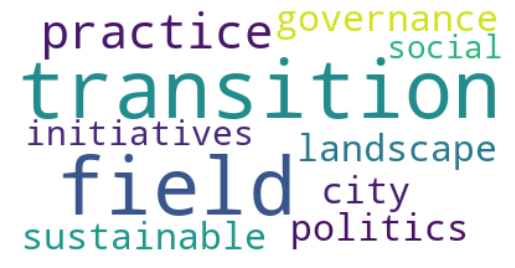

In [28]:
# Show wordcloud
create_wordcloud(topic_model, topic=1)

In [29]:
# Representative docs
rep_doc = topic_model.get_representative_docs()
rep_doc = pd.DataFrame(rep_doc)
rep_doc.T

,0,1,2
-1,creating actionable knowledge one step at a ti...,the changing landscape of deep transitions: so...,societal transformation through the prism of t...
0,zero carbon homes in the uk? analysing the co-...,closing the green finance gap – a systems pers...,evaluating the global impact of low-carbon ene...
1,engaging with multi-system interactions in sus...,households in sustainability transitions: a sy...,exploring the governance and politics of trans...
2,the ev paradox - a multilevel study of why sto...,assessing and comparing german and uk transiti...,understanding the drivers of fleet emission re...
3,"sustainability, justice and equity in food sys...",beyond food for thought – directing sustainabi...,sustainable futures of agro-food? i̇zmir's sus...
4,spatial diffusion and the formation of a techn...,unrelated diversification in latecomer context...,dynamics of a policy-driven market: the co-evo...
5,understanding the limits to forming policy-dri...,an evolving risk perspective for policy instru...,conceptualizing market formation for transform...
6,assessing the impact of environmental innovati...,diffusion of environmental innovations: sector...,effects of third-party information on the dema...
7,a system dynamics model of socio-technical reg...,the economics of transition pathways: a propos...,influences of technological and sectoral conte...


In [30]:
embeddings = topic_model.embedding_model.embed_documents(docs.loc[:,'text'])
pd.DataFrame(embeddings).to_csv('embeddings_specter.csv')

In [32]:
topic_model.visualize_documents(docs.loc[:,'text'], embeddings=embeddings)

## Visualize Topic Hierarchy

* The topics that were created can be hierarchically reduced.
* In order to understand the potential hierarchical structure of the topics, we can create clusters and visualize how they relate to one another.
* This might also help selecting an appropriate nr_topics when reducing the number of topics that you have created.

In [33]:
# Calculate Hirarchy
hierarchical_topics = topic_model.hierarchical_topics(docs.loc[:,'text'])

100%|██████████| 7/7 [00:00<00:00, 17.24it/s]


In [34]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [36]:
# Run the visualization with the original embeddings
topic_model.visualize_hierarchical_documents(docs.loc[:,'text'], hierarchical_topics, embeddings=embeddings)

IndexError: ignored

## Topics over time

In [37]:
# Calculate topics over time
topics_over_time = topic_model.topics_over_time(docs.loc[:,'text'],
                                                docs.loc[:,'PY'])

13it [00:04,  2.90it/s]


In [38]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=50)

## Visualize Topic Similarity
Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [39]:
topic_model.visualize_heatmap(n_clusters=5, width=1000, height=1000)

# Optimal: Finetune topics

Only do if you think something should be changes

In [ ]:
# VECTORIZER: custom vectorizer to get rid of stopwords
#vectorizer_model = CountVectorizer(stop_words=stpwrd, min_df = 10)

# TFIDF Weighting: Weighting model with redued stoppwords
#ctfidf_model = ClassTfidfTransformer(bm25_weighting=True,reduce_frequent_words=True)

## REPRESENTATION MODEL:
# rep_mm = MaximalMarginalRelevance(diversity=0.8)
# rep_kb = KeyBERTInspired()
# rep_oai = OpenAI()
# representation_model = rep_mm # [rep_mm, rep_kb]

# topic_model.update_topics(docs.loc[:,'text'], n_gram_range=(1, 3),
#                          vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model, representation_model=representation_model)

In [ ]:
# Reduce topics if wanted
# topic_model.reduce_topics(docs, nr_topics=30)

## Visualize Topic Probabilities

- The variable `probabilities` that is returned from `transform()` or `fit_transform()` can  be used to understand how confident BERTopic is that certain topics can be found in a document.



In [40]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs.loc[:,'text'], calculate_tokens=True)

100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


In [41]:
# Select a document
doc_nr = 102
docs.loc[doc_nr,'text']

'systems of practice and the circular economy: transforming mobile phone product service systems. of late, policy and research attention has increasingly focused on making the circular economy a reality. a key part of this agenda is the creation of sustainable product service systems (spss) that meet consumers’ needs whilst lessening negative environmental impacts. although the spss literature has grown recently, key aspects require further examination. in response, this paper discusses empirical research exploring consumers’ reactions to a novel, hypothetical mobile phone spss, utilizing qualitative methods that included ‘business origami’. it examines consumers’ knowledge about current mobile phone life cycles, and responses to the proposed spss, drawing on a ‘systems of practice’ framework to discuss the potential for significant changes in phone purchase and use. it outlines barriers to alterations in practices, underscoring the centrality that connectivity and data storage now hav

In [42]:
# Get the probability distribution
topic_model.visualize_distribution(probs[doc_nr], min_probability=0.01)

In [44]:
# Visualize the token-level distributions
doc_topic_dist = topic_model.visualize_approximate_distribution(docs.loc[doc_nr,'text'], topic_token_distr[doc_nr])
doc_topic_dist

,systems,of,practice,and,the,circular,economy,transforming,mobile,phone,product,service,systems,of,late,policy,and,research,attention,has,increasingly,focused,on,making,the,circular,economy,reality,key,part,of,this,agenda,is,the,creation,of,sustainable,product,service,systems,spss,that,meet,consumers,needs,whilst,lessening,negative,environmental,impacts,although,the,spss,literature,has,grown,recently,key,aspects,require,further,examination,in,response,this,paper,discusses,empirical,research,exploring,consumers,reactions,to,novel,hypothetical,mobile,phone,spss,utilizing,qualitative,methods,that,included,business,origami,it,examines,consumers,knowledge,about,current,mobile,phone,life,cycles,and,responses,to,the,proposed,spss,drawing,on,systems,of,practice,framework,to,discuss,the,potential,for,significant,changes,in,phone,purchase,and,use,it,outlines,barriers,to,alterations,in,practices,underscoring,the,centrality,that,connectivity,and,data,storage,now,have,in,many,peoples,daily,lives,which,have,for,some,become,clustered,around,the,capabilities,and,accessibility,of,the,mobile,phone
2_niche_innovation_technology_companies,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.108,0.108,0.108,0.108,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6_eco_environmental_innovation_determinants,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.102,0.205,0.205,0.205,0.102,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.103,0.209,0.311,0.311,0.208,0.102,0.000,0.000,0.000,0.000,0.000,0.114,0.114,0.114,0.114,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


# Work in progress: Manual ChatGTP topic summary:

In [52]:
top_n = 7
n_doc = hdbscan_min_cluster_size

promt_intro = "I want you to act as a professor in social science. I want you to identify the reearch topic of following documents, which are titles plus abstacts of scientific journal article publications. They are representative articles for the topic to be identified. The journal is called  'Environmental Innovation and Societal Transitions'. The journal offers a platform for reporting studies of innovations and socio-economic transitions to enhance an environmentally sustainable economy and thus solve structural resource scarcity and environmental problems, notably related to fossil energy use and climate change. This involves attention for technological, organizational, economic, institutional and political innovations as well as economy-wide and sector changes, such as in the areas of energy, transport, agriculture and water management. The journal aims to tackle the most difficult questions, dealing with social, economic, behavioral-psychological and political barriers and opportunities as well as their complex interaction. The journal is multidisciplinary in spirit and methodologically open, and invites contributions from a broad range of disciplines within the social, environmental and innovation sciences. Specific research areas covered include: Theoretical analysis, formal modeling, empirical studies, policy discussion and a critical survey of relevant literature. Practical cases may address transitions in specific sectors, cities or regions. Articles on historical transitions not specifically related to environment and sustainability are welcome if they include a section with unique lessons for sustainability transitions. A non-exhaustive list of keywords and themes is as follows: behavior in line with bounded rationality, development theories, diffusion of innovations, environmental regulation, formal modeling, geography of innovations, historical transitions, increasing returns to scale and path dependence, innovation policy, institutional barriers, international cooperation and coordination, learning-by-doing, learning curves, lock-in, new governance, niche markets, optimal technological diversity, regime analysis, social and political power, strategic niche management, rebound effect, recombinant innovation, sector structure, social learning, transition experiments, technological regimes, transition pathways/mechanisms, vested interests, visions of the future."

promt_doc_intro = "Now I provide you the 10 articles. Every article starts with an '-', and ends with a linebreak:"
promt_doc = topic_model.get_document_info(docs.loc[:,'text']).sort_values(['Representative_document', 'Probability'],ascending=False).groupby('Topic').head(n_doc)
promt_doc['Document'] = '- ' + promt_doc['Document']
promt_doc = promt_doc.groupby('Topic', as_index=False).agg({'Document' : ' \n '.join}).query("Topic == @top_n").reset_index().loc[0,'Document']
promt_key_intro = "Now that your recieved the corresponding documents, I will also provide you some keywords describing the topic. They are sepperated with an ','"

promt_key = pd.DataFrame(topic_model.get_topic(top_n))
promt_key = [', '.join(promt_key.loc[:,0])]

promt_final = "Your task is to summarize the topic by a short label of 2-7 words, plus a short description of 3-5 sentences. It should consider the article content and the provided keywords, both against the background of the journal they are published in. It should be brief, focussed, clear, and avoid redundancies. This summary should highlight the commonality of the documents. It should indicate the main theoretical theme, research framework applied, context, potential contributions and implications. It should also indicate if the research in this topic is more quantitative or qualitative, on a macro or micro level, and aimed at theoretical, policy, or industry implications."

print(promt_intro, promt_doc_intro, promt_doc, promt_key_intro, promt_key, promt_final, sep = " \n \n ")

I want you to act as a professor in social science. I want you to identify the reearch topic of following documents, which are titles plus abstacts of scientific journal article publications. They are representative articles for the topic to be identified. The journal is called  'Environmental Innovation and Societal Transitions'. The journal offers a platform for reporting studies of innovations and socio-economic transitions to enhance an environmentally sustainable economy and thus solve structural resource scarcity and environmental problems, notably related to fossil energy use and climate change. This involves attention for technological, organizational, economic, institutional and political innovations as well as economy-wide and sector changes, such as in the areas of energy, transport, agriculture and water management. The journal aims to tackle the most difficult questions, dealing with social, economic, behavioral-psychological and political barriers and opportunities as wel

## Results

### Topic 0: Socio-Technical Transitions for Sustainability
This topic revolves around the study of socio-technical transitions, primarily in the energy sector, towards sustainable practices. The focus is on exploring the interaction between technology, policy, and societal responses to achieve sustainable growth, climate stability, and environmental conservation. The research covers multiple geographical contexts like the UK, the US, and India, and spans various energy sub-sectors including housing, green finance, and renewable technologies such as solar and wind power. It relies on a blend of qualitative and quantitative approaches, using theoretical frameworks like multi-level perspective (MLP), system innovation, policy mix, and innovation system analysis. The implications of these studies are multi-fold, providing theoretical insights, policy recommendations, and strategic directions for industry players and stakeholders involved in sustainable transitions.

### Topic 1: Governance and Politics in Sustainability Transitions
This topic focuses on the role of governance, politics, and social aspects in facilitating transitions towards sustainability, particularly in urban environments. Researchers utilize theoretical frameworks such as multi-level perspectives and complex adaptive systems to understand the dynamics of transitions, and the ways in which institutions, policies, and social actors can drive or hinder them. Key contexts include urban land use, transport infrastructure, energy systems, and the role of intermediary organizations in policy design. Research is largely qualitative and operates on a macro level, engaging with policy design and theoretical advancement. The contributions are poised to provide valuable insights for policy makers, practitioners, and scholars in understanding how to navigate the complexities of sustainability transitions.

### Topic 2: Policy Impact on Electric Vehicle Transition
This topic focuses on understanding how different policies influence the transition towards electric vehicles (EVs) in the automotive sector, often from a socio-technical transitions perspective. A central research theme is the exploration of the influence of policy on incumbent and niche firms, their technological innovations, learning processes, and the interaction of these factors in various countries. The studies are typically qualitative, analyzing policy impacts at a macro level, with the application of theoretical frameworks like multi-level perspective and agent-based modelling. Research in this area has implications for both policy development and industry strategy, helping to identify effective measures for promoting EV adoption and overcoming technological lock-ins.

### Topic 3: Sustainable Transitions in Agri-Food Systems
This topic revolves around understanding the dynamics, challenges, and possibilities of sustainable transitions in agri-food systems across various global contexts. It encompasses the exploration of factors such as social justice, policy influence, local cultural and ecological factors, resilience, and public perception. These studies predominantly employ a qualitative research approach, utilizing theories and frameworks like the multi-level perspective, innovation system, and resilience in agri-food transitions. The research context spans from developed to developing countries, rural to urban areas, and includes various stakeholders such as farmers, grassroots organizations, and policymakers. Insights from this research could greatly contribute to the formulation of policies, strategies, and practices that could facilitate more sustainable, equitable, and inclusive transitions in agri-food systems.

### Topic 4: Innovation and Spatial Diffusion in Clean Technologies
Topic Description: This research area is primarily focused on the study of spatial diffusion, international markets, regional specialisations, and the role of policy in promoting clean and renewable energy technologies, with a particular emphasis on wind energy and cleantech. The predominant theoretical framework applied is the Technological Innovation Systems (TIS), coupled with case study and agent-based modelling approaches. Most of the studies have a macro perspective, exploring international and regional dynamics, with a strong emphasis on China, Germany, and European regions. The research appears to be more qualitative, analyzing specific case studies and using patents as a proxy for innovation. The potential contributions are both theoretical, by extending the understanding of the TIS in a global context, and practical, by providing policy implications to support the diffusion and development of clean technologies.

### Topic 5: Innovation and Spatial Diffusion in Clean Technologies
This research area is primarily focused on the study of spatial diffusion, international markets, regional specialisations, and the role of policy in promoting clean and renewable energy technologies, with a particular emphasis on wind energy and cleantech. The predominant theoretical framework applied is the Technological Innovation Systems (TIS), coupled with case study and agent-based modelling approaches. Most of the studies have a macro perspective, exploring international and regional dynamics, with a strong emphasis on China, Germany, and European regions. The research appears to be more qualitative, analyzing specific case studies and using patents as a proxy for innovation. The potential contributions are both theoretical, by extending the understanding of the TIS in a global context, and practical, by providing policy implications to support the diffusion and development of clean technologies.

### Topic 6: Environmental Innovations: Drivers and Impacts
Topic Description: The research topic primarily investigates the determinants and impacts of environmental or eco-innovations, with an emphasis on different sectors and geographic contexts, including emerging economies. These studies examine the factors influencing the development, diffusion, and adoption of eco-innovations, the role of regulations and market forces, and their effects on economic competitiveness and operational efficiency. A mix of quantitative and qualitative research methods are used, with some applying the concept of 'lead markets' and Technological Innovation Systems (TIS) framework. The topic operates at both macro (cross-national) and micro (firm-level) scales. Implications of this research are multifaceted, contributing to theoretical discussions, informing policy decisions, and offering insights for industry strategy regarding environmental innovations.

### Topic 7: Sociotechnical Transitions and Innovation Systems
This research topic delves into the dynamics and mechanisms of sociotechnical transitions, focusing particularly on Technological Innovation Systems (TIS) and the Multi-Level Perspective (MLP). It explores how technologies emerge, diffuse, compete and phase out in different sectoral and geographical contexts, highlighting the role of various actors, institutional entrepreneurship, and the complex interplay between technological systems and their wider contextual structures. The methodology leans toward a combination of conceptual analysis and case studies, suggesting a balance of qualitative and quantitative approaches. The implications of this research are multi-dimensional, enriching theoretical discourse, informing public policy around technology phase-out and transitions, and providing valuable insights for industry strategy and practices.